# **1. The Portfolio Optimization Task**

---

This is a common task in the field of finance. The main goal is to determine the optimal allocation of capital among a set of available assets (stocks) to achieve the highest possible expected return. A portfolio is defined by a set of weights, $w$, where each weight $w_i$ represents the fraction of the total capital invested in asset $i$.

# **The Capital Asset Pricing Model (CAPM)**

---


To quantify the expected return for each asset, we can use the Capital Asset Pricing Model (CAPM). It provides a theoretical framework for determining the expected return of an asset based on its systematic risk in relation to the overall market, and is given by:

$$
E(R_i) = R_f + \beta_i \left( E(R_m) - R_f \right)
$$

Where:
- $E(R_i)$ is the expected return of asset $i$.
- $R_f$ is the risk-free rate of return. This is the theoretical return of an investment with zero risk, often represented by the yield on a government treasury bond.
- $E(R_m)$ is the expected return of the overall market.
- $\beta_i$ is a measure of an asset's volatility or systematic risk compared to the market.

  - $\beta_i = 1$ implies the asset moves in line with the market.
  - $\beta_i > 1$ implies the asset is more volatile than the market.
  - $\beta_i < 1$ implies the asset is less volatile than the market.

<br>

$\left( E(R_m) - R_f \right)$ is also known as the market premium.

## **Objective Function and Constraints**

---

Using the CAPM, we can define the total expected return of the portfolio, $E(R_p)$, as the weighted sum of the individual asset returns. Our goal is to maximize:

$$
E(R_p) = \sum_{i=1}^{n} w_i E(R_i)
$$

Subject to a set of linear constraints:

$$
\begin{aligned}
\max \quad & \sum_{i=1}^n w_i E(R_i) \\
\text{subject to} \quad & \sum_{i=1}^n w_i = 1 \quad \text{(Budget constraint)} \\
& w_i \geq 0 \quad \forall i \in \{1, \dots, n\} \quad \text{(No short selling)} \\
& w_i \leq w_{\max} \quad \forall i \in \{1, \dots, n\} \quad \text{(Diversification)}
\end{aligned}
$$
<br>

*   **Budget Constraint**: The sum of all weights must equal 1, ensuring that 100% of the capital is invested.
*   **No Short Selling**: The weight of each asset must be non-negative as we are not selling any stock.
*   **Diversification**: To prevent over-concentration in a single asset, we impose an upper limit on the weights.
<br>

Since the objective function and all constraints are linear, this problem is a classic example of Linear Programming.

## **Parameters**

---
The portfolio optimization task will be evaluated for a set of stocks belonging to the Colombian market. The constants $\beta_i$ for each stock $i$ are taken from a webpage that provides financial data speclialized for traders (https://www.tradingview.com/markets/stocks-colombia/market-movers-high-beta/). The Risk free Rate and the Market Premium are currently estimated to be 12.99% and 6% respectively (https://www.gurufocus.com/term/wacc/EC).

The decision variable to be optimized in this case is the vector of weights $w$. The solution of the optimization task will be imlpemented with the Pyomo package for python and the IPOPT solver that uses Internal Point Methods.

# **Linear Programming - Path-Following Primal-Dual Interior-Point Method**

---

Interior point methods for Linear Programming (LP) are an extension of Primal-Dual methods. They are powerful algorithms that traverse the interior of the feasible region, unlike the simplex method which moves along the edges. Specifically, the central path method is a prominent type of interior point method that works by formulating a sequence of perturbed problems, each with a strictly convex objective function, whose solutions form a path (the central path) that converges to an optimal solution of the original LP.

Let's consider a linear programming problem in standard form:
<br>

$$
\min c^T x,  \ \ \text{subject to} \ Ax = b, \  \ x \geq 0
$$
<br>

where $c$ and $x$ are vectors in $\mathbb{R}^{n}$, $b$ is a vector in $\mathbb{R}^{m}$, and $A \in \mathbb{R}^{m \times n}$ is full row rank.

The dual problem is given by:
<br>

$$
\max b^T \lambda,  \ \ \text{subject to} \ A^T\lambda + s = c, \  \ s \geq 0
$$
<br>

where $\lambda \in \mathbb{R}^{m}$ and $s \in \mathbb{R}^{n}$.

The solutions for this primal-dual pair are characterized by the KKT conditions:

$$
\begin{aligned}
A^T\lambda + s = c \\
Ax = b \\
x_is_i = 0, \ i = 1, 2, ..., n \\
(x, s) \geq 0
\end{aligned}
$$

Primal-dual methods find solutions $(x^*, \lambda^*, s^*)$ by applying variants of Newton's method to the equalities and modifying the search direction and step length so that the inequalities are satisfied at every iteration.

Specifically, Interior-point methods take a Newton step toward the point for which $x_is_i = \sigma\mu$, where $\mu$ is the current duality measure and $\sigma \in [0, 1]$ is the reduction factor for the duality measure on this step. $\sigma$ is called the centering parameter.

The general steps for a Primal-Dual Path-Following algorithm are as follow:

<img src='https://drive.google.com/uc?id=1vMudpb7jeXXazH71760X4DExIpCYfMgD' width="580" height="400">

# **Code**


---

In [ ]:
# Install Pyomo
!pip install pyomo

# Install the ipopt solver
!wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64

In [ ]:
# Importing needed libraries

import numpy as np
import matplotlib.pyplot as plt

# --- System libraries for data extraction from solver log
import io
import re
from contextlib import redirect_stdout

# --- Optimization solvers
import pyomo.environ as pyo

# --- Analysis metrics
from sklearn.metrics import r2_score

## **Function definitions**


---

In [ ]:
def asset_betas():

    ################################################################################
    # Sets beta (β - Volatility relative to the market) values for each stock
    ################################################################################

    betas_dict = {
        'bvc': 0.45,
        'cemargos': 0.94,
        'ecopetrol': 0.54,
        'nutresa': 0.25,
        'fabricato': 1.28,
        'cibest': 1.35,
        'isa': 1.57,
        'gruposura': 0.78,
        'celsia': 0.56,
        'terpel': 0.53,
        'entelco': 0.45,
        'etb': 0.14,
        'proteccion': -0.02,
        'exito': -0.07,
        'occidente': -0.32,
        'coltel': 0.00,
        'popular': 0.01,
        'bogota': 0.62,
        'grubolivar': 0.89,
        'corficolcf': 1.22
    }

    assets = list(betas_dict.keys())

    return assets, betas_dict

In [ ]:
def obj_function(model):

    ################################################################################
    # Computes the portfolio return based on the Capital Asset Pricing Model (CAPM)
    ################################################################################
    # --- Computes the sum of expected returns for each asset
    total_expected_return = sum(model.expected_return[i] * model.w[i] for i in model.assets)

    return total_expected_return

In [ ]:
class constraints():

    ################################################################################
    # Defines the constraints for the optimization problem
    ################################################################################

    def budget(model):
        # --- Budget constraint - The sum of investments on each stock can't be
        # greater than the 100% of the budget
        return sum(model.w[i] for i in model.assets) == 1.0

    def diversification(model, i):
        # --- Diversificaction constraint - A single stock can't be more than
        # 30% of the portfolio
        return model.w[i] <= 0.3


# **Path-Following Interior-Point Method**


---



In [ ]:
################################################################################
# Linear Programming - Path-Following Interior-Point Method
################################################################################
# --- Problem constants
assets, betas = asset_betas() # Define the betas for the different stocks

# --- Problem Variables - Needed for the CAPM calculation
risk_free_rate = 0.1299 # Currently is 12.99% for Colombian market
market_premium = 0.06 # 6% according to the economic indicators

# --- Defines the expected return for each asset using the CAPM equation
asset_return = {
    asset: risk_free_rate + betas[asset] * market_premium
    for asset in assets
}

# --- Create Pyomo model to solve the LP
model = pyo.ConcreteModel(name='Assets_Portfolio_Optimization(CAPM)')
# --- Define parameters for the model
model.assets = pyo.Set(initialize=assets)
model.expected_return = pyo.Param(model.assets, initialize=asset_return)
# --- Define the decision variable (w_i is the portion of budget invested in asset i)
model.w = pyo.Var(model.assets, bounds=(0, 1))
# --- Define objective function
model.obj = pyo.Objective(rule=obj_function, sense=pyo.maximize)
# --- Define constraints
model.budget_constraint = pyo.Constraint(rule=constraints.budget)
model.diversification_constraint = pyo.Constraint(model.assets, rule=constraints.diversification)

# --- Runs the interior point method to solve the LP
solver = pyo.SolverFactory('ipopt')
# --- Capture the stdout from the solver
log_stream = io.StringIO()
with redirect_stdout(log_stream):
    results = solver.solve(model, tee=True)
# --- Get captured log as string
solver_log = log_stream.getvalue()

# --- Prints solver results
print(f"Solver Status: {results.solver.status}")
print(f"Termination Condition: {results.solver.termination_condition}\n")
# --- If solver found a solution prints assets to invest in
if results.solver.termination_condition == pyo.TerminationCondition.optimal:
    print("--- Optimal Portfolio Weights ---")
    total_return = pyo.value(model.obj)
    for i in model.assets:
        weight = pyo.value(model.w[i])
        if weight > 1e-6: # Only print assets that are invested in
            print(f"  {i:<5}: {weight:.2%}")
    # --- Portfolio return for the optimal investments
    print(f"\nMaximum Expected Portfolio Return: {total_return:.2%}")
else:
    print("Could not find an optimal solution.")

Solver Status: ok
Termination Condition: optimal

--- Optimal Portfolio Weights ---
  fabricato: 30.00%
  cibest: 30.00%
  isa  : 30.00%
  corficolcf: 10.00%

Maximum Expected Portfolio Return: 21.28%


## **Analysis and plotting**


---

Weigth for bvc: 0.00
Weigth for cemargos: 0.00
Weigth for ecopetrol: 0.00
Weigth for nutresa: 0.00
Weigth for fabricato: 0.30
Weigth for cibest: 0.30
Weigth for isa: 0.30
Weigth for gruposura: 0.00
Weigth for celsia: 0.00
Weigth for terpel: 0.00
Weigth for entelco: 0.00
Weigth for etb: 0.00
Weigth for proteccion: 0.00
Weigth for exito: 0.00
Weigth for occidente: 0.00
Weigth for coltel: 0.00
Weigth for popular: 0.00
Weigth for bogota: 0.00
Weigth for grubolivar: 0.00
Weigth for corficolcf: 0.10


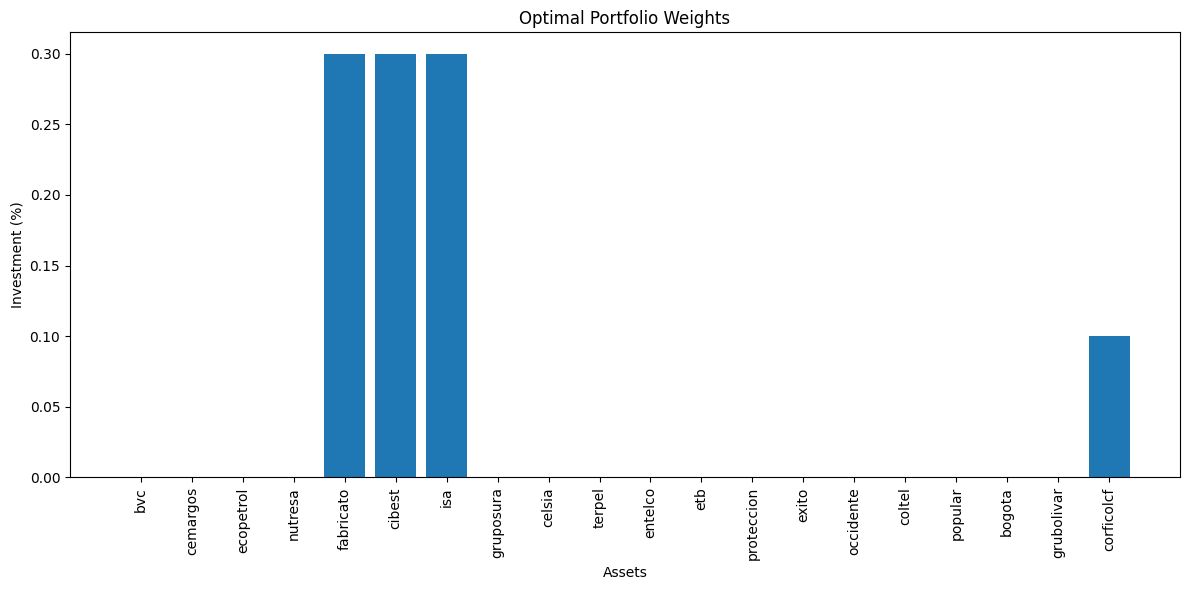

In [ ]:
################################################################################
# Prints resulting parameters (optimized)
################################################################################
for i in model.assets:
    print('Weigth for {}: {:.2f}'.format(i, pyo.value(model.w[i])))

plt.figure(figsize=(12, 6)) # Increase figure size for better readability
plt.bar(model.assets, [pyo.value(model.w[i]) for i in model.assets])
plt.xticks(rotation=90) # Rotate x-axis labels by 90 degrees
plt.xlabel("Assets")
plt.ylabel("Investment (%)")
plt.title("Optimal Portfolio Weights")
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()

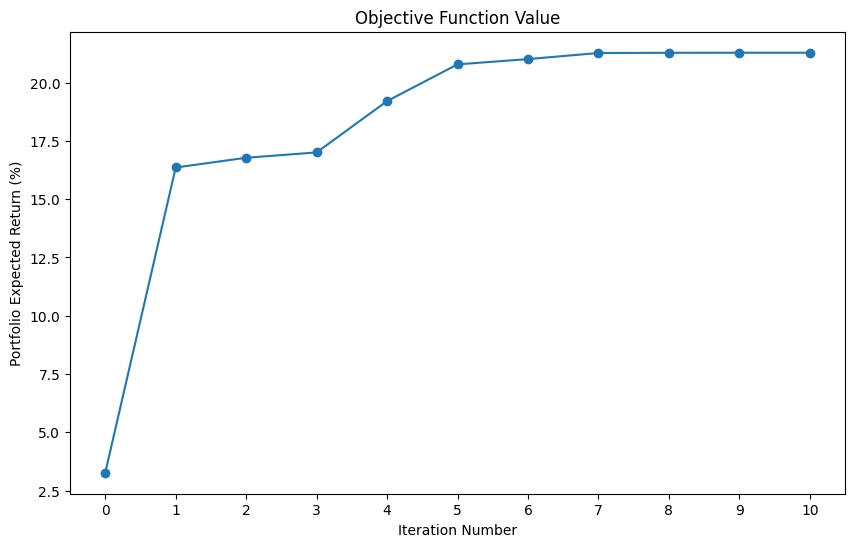

In [ ]:
################################################################################
# Plotting simulation error curve (objective function)
################################################################################
# --- Parse the log and extract data
iterations = []
objective_values = []

# --- Captures iteration number and objective function value from ipopt solver
pattern = re.compile(r"^\s*(\d+)\s+([+\-\d.eE]+)\s+")

for line in solver_log.split('\n'):
    match = pattern.match(line)
    if match:
        # --- Iteration number
        iterations.append(int(match.group(1)))
        # --- Objective value in percentage (negate it back to maximization)
        objective_values.append(-float(match.group(2)) * 100)

# --- Plot Objective function value per iteration
if iterations:
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, objective_values, marker='o', linestyle='-')
    plt.title('Objective Function Value')
    plt.xlabel('Iteration Number')
    plt.ylabel('Portfolio Expected Return (%)')
    plt.xticks(iterations)
    plt.show()

# **2. Sparse Coding**

---

Sparse coding is a computational framework that seeks to represent signals as linear combinations of a few selected vectors from an overcomplete dictionary. An overcomplete dictionary means that the number of basis vectors $m$ is greater than the dimensionality of the signal $n$. In such case, there are infinitely many ways to represent a given signal using the dictionary. The goal of sparse coding is to find the sparsest possible representation, meaning the one with the fewest non-zero coefficients.

Sparsity is important in fields like Artificial Intelligence and Computational Neuroscience as it provides interpretability to data as well as noise robustness and efficiency improvements to algorithms.

# **The LASSO Optimization Problem**

---

The Least Absolute Shrinkage and Selection Operator (LASSO) is a widely used regularization technique in statistics and machine learning, particularly for models involving high-dimensional data. At its core, LASSO addresses the problem of finding a parsimonious representation of a signal or data by promoting sparsity in the solution.

Mathematically, the LASSO optimization problem can be formulated as:

$$
\min_{\beta \in \mathbb{R}^p} \|y - X\beta\|_2^2 \quad \text{subject to} \quad \|\beta\|_1 \leq t
$$

where $t \geq 0$ is the tunning parameter.

The sparsity property of the LASSO problem can be shown by its geometric characteristics. The contour of the squared error loss hits the constraint set given by the $l_1$ ball with higher probability at its sharp corners:

<img src='https://drive.google.com/uc?id=1_v0DSBujSLsppeMLQzSt_eKm0LPTuTOj' width="300" height="330">

Furthermore, it has yet another important property: It is a convex optimization problem.

## **Parameters**

---

For the current excercise, we will be using a custom target signal $y$ and a set of features conforming a basis, given by the dictionary of features $X$. The goal is to find a sparse subset of features from the $X$ that approximates $y$ with enough accuracy, thus $X\beta$ is a sparse version of $y$, where the vector $\beta$ is the decision variable to optimize.

The basis used is built by a set of sinusoidal signals with varying frequency.

# **Quadratic Programming - Interior-Point Methods**

---

The Interior-Point approach can be applied to convex quadratic programms through a simple extension of the linear programming algorithms. A convex quadratic program with inequality constraints is defined by:

$$
\begin{aligned}
\min_{x} \quad & q(x) = \frac{1}{2} x^T G x + x^T c \\
\text{subject to} \quad & Ax \geq b
\end{aligned}
$$

where $G$ is symmetric and positive semidefinite, and:

$$
A = [a_i]_{i \in \mathcal{I}}, \quad b = [b_i]_{i \in \mathcal{I}}, \quad \mathcal{I} = \{1, 2, \ldots, m\}
$$
<br>

By introducing a slack vector $y \geq 0$, the KKT conditions in this case can be written as:

$$
\begin{aligned}
Gx - A^T \lambda + c &= 0, \\
Ax - y - b &= 0, \\
y_i \lambda_i &= 0, \quad i = 1, 2, \ldots, m \\
(y, \lambda) &\ge 0
\end{aligned}
$$
<br>
<br>

A path-following primal-dual method can be defined by considering the perturbed KKT conditions given by:

$$
F(x, y, \lambda; \sigma\mu) = \begin{bmatrix}
Gx - A^T \lambda + c \\
Ax - y - b \\
Y\Lambda e - \sigma\mu e
\end{bmatrix} = 0
$$

where $\sigma \in [0, 1]$ and:

$$
\mathcal{Y} = \mathrm{diag}(y_1, y_2, \dots, y_m), \quad \Lambda = \mathrm{diag}(\lambda_1, \lambda_2, \dots, \lambda_m), \quad e = (1,1,\dots,1)^T
$$

Here, $\mu$ is a complementarity measure defined by:

$$
\mu = \frac{y^T \lambda}{m}
$$

at a current iteration satisfying $(y, \lambda) \ > \ 0$.
<br>

The solutions of the system for all positive values of $\sigma$ and $\mu$ define a trajectory, called the central path, that leads to the solution of the quadratic program as $\sigma$ $\mu$ tends to zero.

## **Function definitions**


---

In [ ]:
def load_target_signal():

    ################################################################################
    # Loads target signal to be aproximated
    ################################################################################

    target_signal = np.load('sig.npy')

    return target_signal

In [ ]:
def create_features(target_signal, length, time):

    ################################################################################
    # Creates the feature dictionary using sinusoidal signals
    ################################################################################

    # --- 100 different frequency values from 0.001 to 1, then apply each frequency on time
    freqs = np.linspace(0.01, 10, 200)
    x = {}
    x_array = np.array([])
    for i, f in enumerate(freqs):
        for j in range(length):
            x[i, j] = np.sin(time[j]*f)
        x_array = np.append(x_array, np.sin(time*f), axis=0)
    x_array = x_array.reshape(i+1, length)

    return x, x_array, i, freqs

In [ ]:
def obj_function(model):

    ################################################################################
    # Computes the MSE for the target and approximated signals
    ################################################################################
    # --- Computes MSE
    se = sum((model.target_signal[i] - sum(model.features[j, i] * model.w[j] for j in model.M))**2 for i in model.N)

    return 0.5 * se

In [ ]:
class constraints():

    ################################################################################
    # Defines the constraints for the optimization problem
    ################################################################################

    def l1_norm(model):
        # --- L1-norm constraint - sum(|w_j|) <= t
        return sum(model.z[j] for j in model.M) <= t

    def positive_abs(model, j):
        # --- Positive absolute values - w_j <= z_j
        return model.w[j] <= model.z[j]

    def negative_abs(model, j):
        # --- Negative absolute values - -w_j <= z_j
        return -model.w[j] <= model.z[j]

# **Path-Following Interior Point Method**


---



In [ ]:
################################################################################
# Quadratic Programming - Path-Following Interior Point Method
################################################################################
# --- Loads target data
target_signal = load_target_signal()
# --- Sets number of samples
N = target_signal.shape[0]
# --- Defines a time vector for the signals
time = np.arange(N)
# --- Creates feature dictionary where M is the number of features
features, features_array, M, frequencies = create_features(target_signal, N, time)

# --- Defines the regularization parameter t
t = 600.0

# --- Create Pyomo model to solve the QP
model = pyo.ConcreteModel(name='LASSO_QP_Optimization')
# --- Define model dimensions
model.N = pyo.RangeSet(0, N - 1)
model.M = pyo.RangeSet(0, M)
# --- Define parameters for the model
model.target_signal = pyo.Param(model.N, initialize=target_signal)
model.features = pyo.Param(model.M, model.N, initialize=features)
# --- Define the decision variables - w_i is the weight per feature
model.w = pyo.Var(model.M, domain=pyo.Reals)
# --- Define the decision variables - z_i is the auxiliary variable
#     for the L1-norm constraint
model.z = pyo.Var(model.M, domain=pyo.NonNegativeReals)

# --- Define objective function
model.obj = pyo.Objective(rule=obj_function, sense=pyo.minimize)
# --- Define constraints
model.l1_norm_constraint = pyo.Constraint(rule=constraints.l1_norm)
model.positive_abs_constraint = pyo.Constraint(model.M, rule=constraints.positive_abs)
model.negative_abs_constraint = pyo.Constraint(model.M, rule=constraints.negative_abs)

# --- Runs the interior point method to solve the QP
solver = pyo.SolverFactory('ipopt')
# --- Capture the stdout from the solver
log_stream = io.StringIO()
with redirect_stdout(log_stream):
    results = solver.solve(model, tee=True)
# --- Get captured log as string
solver_log = log_stream.getvalue()

# --- Prints solver results
print(f"Solver Status: {results.solver.status}")
print(f"Termination Condition: {results.solver.termination_condition}\n")
# --- If solver found a solution prints weights for features
if results.solver.termination_condition == pyo.TerminationCondition.optimal:
    print("--- Optimal Feature Weights ---")
    # --- Final value for objective function
    final_error = pyo.value(model.obj)
    # --- Optimal weight
    w_optimal = np.array([pyo.value(model.w[j]) for j in model.M])
    # --- Reconstruct the signal using the optimal coefficients
    reconstructed_signal = features_array.T @ w_optimal
    # --- Signals fit metrics
    print(f"\nMinimum approximation error: {final_error:.2}")
    print(f"\nR^2 score: {r2_score(target_signal, reconstructed_signal):.2}")
    print(f"\nCorrelation coefficient: {np.corrcoef(target_signal, reconstructed_signal)[0,1]:.2}")
else:
    print("Could not find an optimal solution.")

Solver Status: ok
Termination Condition: optimal

--- Optimal Feature Weights ---

Minimum approximation error: 6.2e+05

R^2 score: -0.83

Correlation coefficient: 0.4


## **Analysis and plotting**


---

In [ ]:
################################################################################
# Prints resulting parameters (optimized)
################################################################################
for i in range(len(w_optimal)):
    if w_optimal[i] > 1e-3:
        print('Weigth for feature {}: {:.2f}'.format(i, pyo.value(w_optimal[i])))

Weigth for feature 0: 112.20
Weigth for feature 1: 9.10
Weigth for feature 2: 2.15
Weigth for feature 3: 8.18
Weigth for feature 4: 9.08
Weigth for feature 7: 5.37
Weigth for feature 8: 0.89
Weigth for feature 9: 2.34
Weigth for feature 10: 2.02
Weigth for feature 11: 1.11
Weigth for feature 12: 1.12
Weigth for feature 14: 0.93
Weigth for feature 16: 2.10
Weigth for feature 17: 2.17
Weigth for feature 19: 1.33
Weigth for feature 22: 1.42
Weigth for feature 27: 1.12
Weigth for feature 29: 1.83
Weigth for feature 31: 1.24
Weigth for feature 36: 0.12
Weigth for feature 38: 0.18
Weigth for feature 46: 0.43
Weigth for feature 48: 0.79
Weigth for feature 53: 0.33
Weigth for feature 58: 0.37
Weigth for feature 62: 0.25
Weigth for feature 66: 0.79
Weigth for feature 68: 0.32
Weigth for feature 88: 0.35
Weigth for feature 90: 1.43
Weigth for feature 92: 0.09
Weigth for feature 95: 1.46
Weigth for feature 97: 1.06
Weigth for feature 100: 0.20
Weigth for feature 116: 0.62
Weigth for feature 120: 

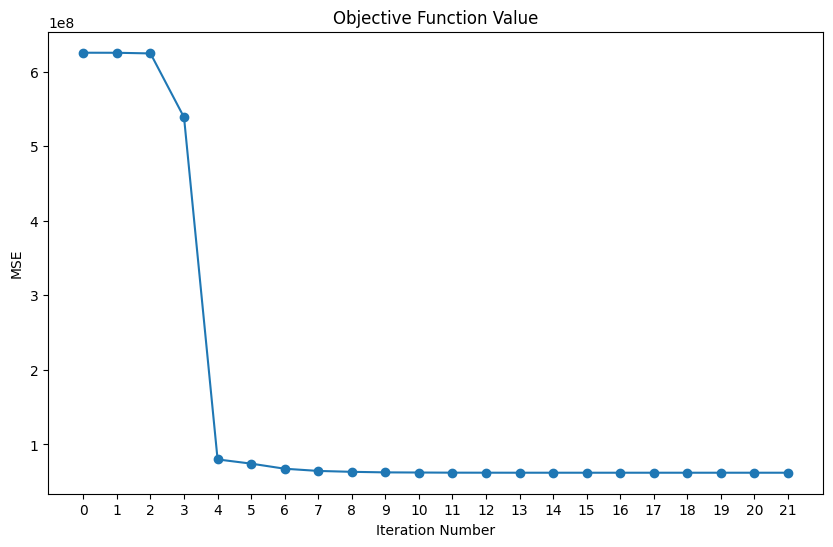

In [ ]:
################################################################################
# Plotting simulation error curve (objective function)
################################################################################
# --- Parse the log and extract data
iterations = []
objective_values = []

# --- Captures iteration number and objective function value from ipopt solver
pattern = re.compile(r"^\s*(\d+)\s+([+\-\d.eE]+)\s+")

for line in solver_log.split('\n'):
    match = pattern.match(line)
    if match:
        # --- Iteration number
        iterations.append(int(match.group(1)))
        # --- Objective value in percentage (negate it back to maximization)
        objective_values.append(float(match.group(2)) * 100)

# --- Plot Objective function value per iteration
if iterations:
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, objective_values, marker='o', linestyle='-')
    plt.title('Objective Function Value')
    plt.xlabel('Iteration Number')
    plt.ylabel('MSE')
    plt.xticks(iterations)
    plt.show()

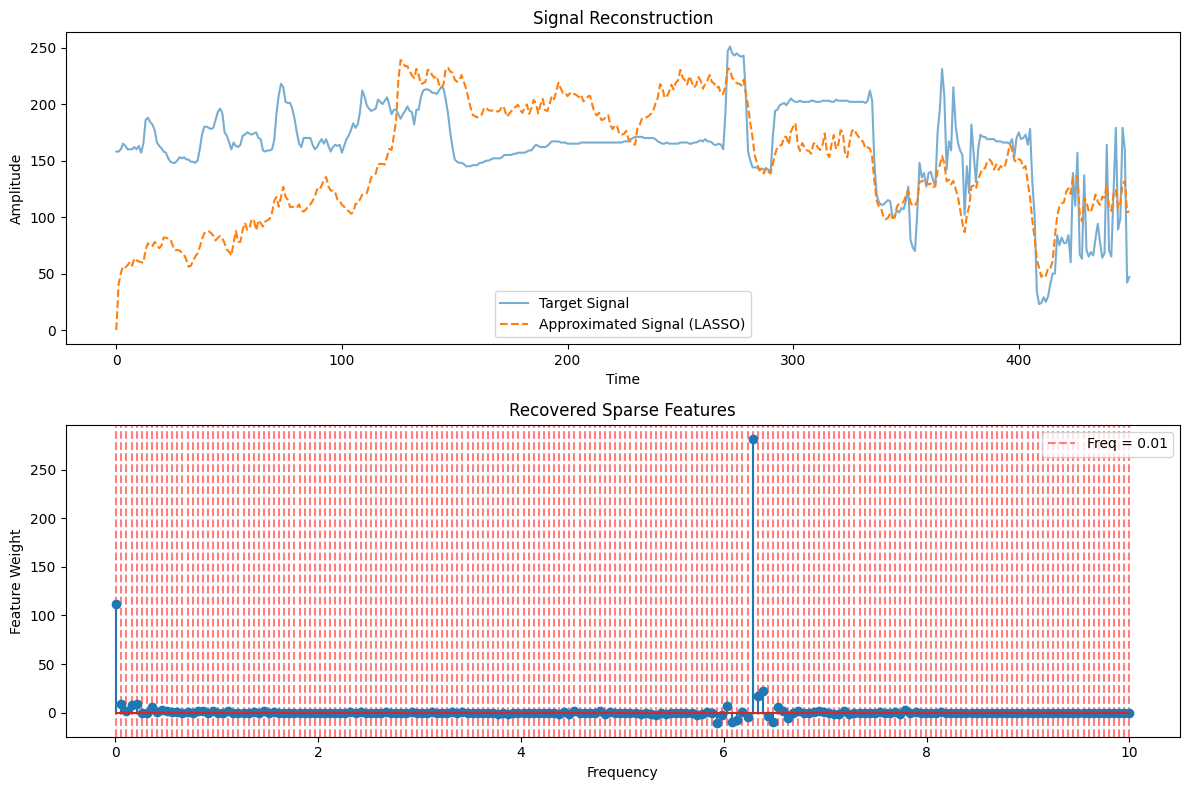

In [ ]:
################################################################################
# Plotting signal reconstruction
################################################################################

# --- Plot Target vs. Approximated Signal
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(time, target_signal, label='Target Signal', alpha=0.6)
plt.plot(time, reconstructed_signal, label='Approximated Signal (LASSO)', linestyle='--')
plt.title('Signal Reconstruction')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

# --- Plot Recovered Sparse Features
plt.subplot(2, 1, 2)
# --- Mark the frequencies in the features dictionary
for freq in frequencies:
    plt.axvline(x=freq, color='red', alpha=0.5, linestyle='--', label=f'Freq = {freq}' if freq==frequencies[0] else "")

plt.stem(frequencies, w_optimal)
plt.title('Recovered Sparse Features')
plt.xlabel('Frequency')
plt.ylabel('Feature Weight')
plt.legend()

plt.tight_layout()
plt.show()